## Custom datasets and handling them


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.__version__

'2.1.1+cu121'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    !nvidia-smi

Thu Nov 23 03:54:01 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.01              Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     On  | 00000000:01:00.0  On |                  N/A |
| N/A   46C    P8               4W /  80W |     90MiB /  6144MiB |     25%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 1. Get data

Our datset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% images(75 training images and 25 testing).

Why do this?

When starting our ML project, it's important to try things on small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can expiriment.

In [3]:


#Setup path to a data folder

data_path = Path("tf-knugs/datasets")
image_path = data_path/ "pizza_steak_sushi"

# If image folder doesnt exist download if it exists then dont download

if image_path.is_dir():
    print(f"{image_path} already exists ..... skipping download")
else:
    print(f"{image_path} doesan't exists ...... creating folder")
    image_path.mkdir(parents=True, exist_ok= True)

#Download data into the folder /tf-knugs/datasets/pizza_steak_sushi

with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downlaoding data ......")
    f.write(request.content)

#Unzip the downlaoded file

with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the dataset")
    zip_ref.extractall(image_path)

tf-knugs/datasets/pizza_steak_sushi already exists ..... skipping download
Downlaoding data ......
Unzipping the dataset


### 2. Data preperationa and data exploration

In [4]:

def walk_through_dir(dir_path):
    """Walks through dir_path returning its content."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        # os.walk() returns a 3-tuple (root, dirs, files)
            # root: current folder "path"
            # dirs: subdirectories in current folder "path"
            # files: files in current folder "path"

        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'tf-knugs/datasets/pizza_steak_sushi'.
There are 3 directories and 0 images in 'tf-knugs/datasets/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'tf-knugs/datasets/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'tf-knugs/datasets/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'tf-knugs/datasets/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'tf-knugs/datasets/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'tf-knugs/datasets/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'tf-knugs/datasets/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'tf-knugs/datasets/pizza_steak_sushi/train/steak'.


In [6]:
# Setup train and test path

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('tf-knugs/datasets/pizza_steak_sushi/train'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test'))

#### 2.1 Visualizing a image

lets write some code to :

1. get all image paths
2. Pick random image path using Python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with the images, let's open the image with Python's PIL
5. Show the image and print some metadat about the images

In [7]:
image_path

PosixPath('tf-knugs/datasets/pizza_steak_sushi')

In [8]:


#Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/1687143.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/398345.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/930553.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/2218680.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_s

In [9]:
#2. Get a random image
random_image_path = random.choice(image_path_list)
random_image_path

PosixPath('tf-knugs/datasets/pizza_steak_sushi/train/steak/2606444.jpg')

In [10]:
#3, Get the image class from the path name
image_class = random_image_path.parent.stem
print(image_class)

steak


Random image path: tf-knugs/datasets/pizza_steak_sushi/train/steak/2606444.jpg
Image class: steak
Image height: 288
Image width: 512


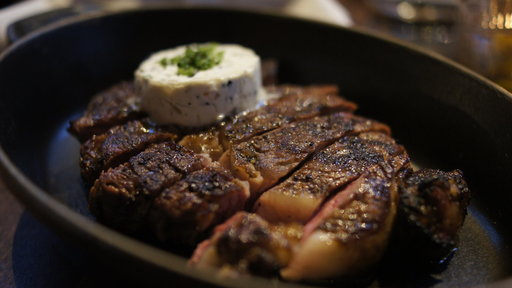

In [11]:
img = Image.open(random_image_path)

#  5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

(-0.5, 511.5, 287.5, -0.5)

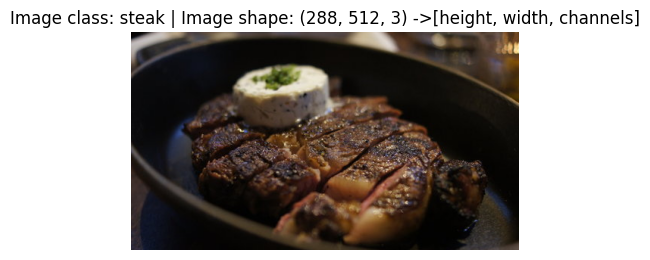

In [12]:
# Turn all images in arrays

img_as_arrays = np.asarray(img)

plt.figure(figsize=(5, 5))
plt.imshow(img_as_arrays)
plt.title(f"Image class: {image_class} | Image shape: {img_as_arrays.shape} ->[height, width, channels]")
plt.axis(False)

### 3. Transforming data

Before any data can be used ot train a model it needs to be converted into tensors.

Here we then convert the tensor into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these dataset and dataloader

In [13]:
# Write a transform for image
data_transform = transforms.Compose([
    #Resize the images to a uniform format (64*64)
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.permute(1,2,0))
])

In [14]:
def plot_transformed_images(image_paths: list, transform, n=3, seed = 42):
    """"Selects random images from a list of images and loads/transforms
    them, then plots the original vs the transforrmed version.
    """
    random.seed(seed)
    random_image_paths = random.sample(population= image_paths, k= n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
           fig, ax = plt.subplots(1,2)
           ax[0].imshow(f)
           ax[0].set_title(f"Original\nSize: {f.size}")
           ax[0].axis(False)

           #Transform and plot target image
           transformed_image = transform(f).permute(1,2,0)
           ax[1].imshow(transformed_image)
           ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
           ax[1].axis(False)

           fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


In [15]:
#Using image folder to create a datset(s)

train_data = datasets.ImageFolder(
    root= train_dir,
    transform= data_transform, # a transformer to transfor data
    target_transform=None, # a transform for label/target
    )

test_data = datasets.ImageFolder(
    root= test_dir,
    transform= data_transform,
    target_transform= None
)
test_data, train_data

(Dataset ImageFolder
     Number of datapoints: 75
     Root location: tf-knugs/datasets/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Lambda()
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: tf-knugs/datasets/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Lambda()
            ))

In [16]:
# Get class name as list
train_data[0][0].shape

torch.Size([64, 64, 3])

#### Data Loader

A `Datalaoder` is going to help us turn our `DataSets` into itrable and we can costumize the batch size so our model can see `batch_size` images at a time

In [17]:
# Turn train and test datasets in dataloader

BATCH_SIZE=32


train_dataLoader = DataLoader(
    dataset = train_data,
    batch_size =BATCH_SIZE,
    shuffle = True,
    num_workers=os.cpu_count()
)

test_dataLoader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 1
)

train_dataLoader, test_dataLoader

(<torch.utils.data.dataloader.DataLoader at 0x7f744f144050>,
 <torch.utils.data.dataloader.DataLoader at 0x7f744f19a790>)

In [18]:
len(train_dataLoader)

8

In [19]:
img, label = next(iter(train_dataLoader))
img.shape, label.shape

(torch.Size([32, 64, 64, 3]), torch.Size([32]))

#### Creating a custom dataset helper function

In [20]:
from cust_Dataset import cust_Dataset

In [21]:
custom_training_dataset = cust_Dataset(
    target_directory= train_dir,
    transformer= data_transform
)
custom_testing_dataset = cust_Dataset(
    target_directory= test_dir,
    transformer= data_transform
)

In [22]:
custom_training_dataset.__len__()

225

In [23]:
# 5.3 Create a function to display random images

# 1. Take in a Dataset as well as a list of class names



def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 5:
        if n > 10:
            n = 10

        else:
            n = n
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 5, setting to 5 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]


        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image.shape}"
        plt.title(title)

In [24]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

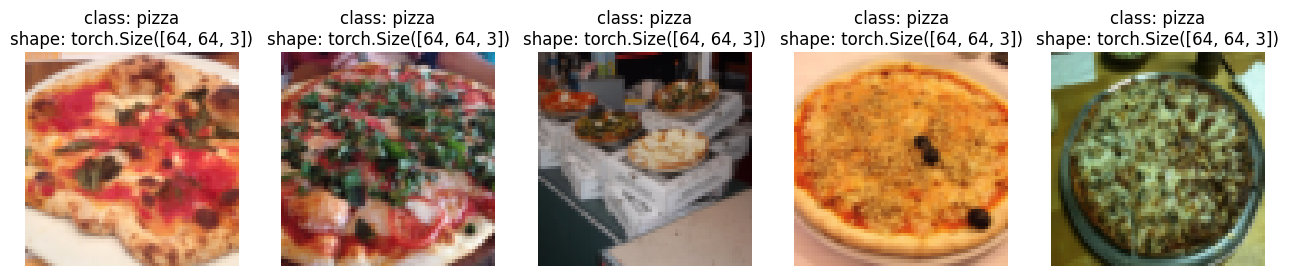

In [25]:
# Display random images from ImageFolder created Dataset

display_random_images(train_data,
                        n=5,
                        classes=class_names,
                        seed=None)

For display purposes, n shouldn't be larger than 5, setting to 5 and removing shape display.


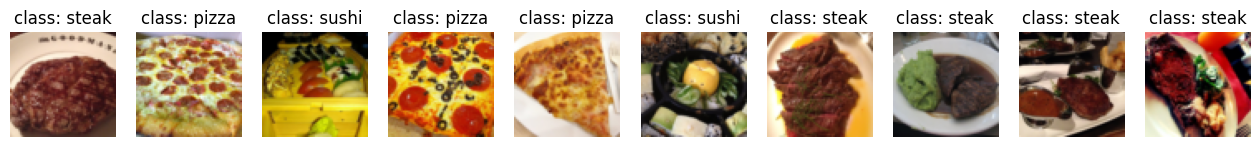

In [26]:
# Display random images from ImageFolder created Dataset

display_random_images(train_data,
                        n=10,
                        classes=class_names,
                        seed=None)

In [27]:
# 5.4 Turn custom loaded images into DataLoader

BATCH_SIZE=32

train_dataLoader_custom = DataLoader(
    dataset = custom_training_dataset,
    batch_size =BATCH_SIZE,
    shuffle = True,
    num_workers=os.cpu_count()
)

test_dataLoader_custom = DataLoader(
    dataset = custom_testing_dataset,
    batch_size =BATCH_SIZE,
    shuffle = False,
    num_workers= 1
)


In [28]:
img_custom, label_custom = next(iter(train_dataLoader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 64, 64, 3]), torch.Size([32]))

In [29]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=32),
    transforms.ToTensor(),
])

test_Transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),

])

In [30]:
# Get all image path

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_sample = random.sample(image_path_list, k=10)
random_sample

[PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/sushi/2715127.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/test/pizza/930553.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/train/pizza/2428085.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/train/pizza/2992084.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/train/steak/2614189.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/train/pizza/715169.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/train/sushi/1221830.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/train/sushi/2980779.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/train/pizza/2702825.jpg'),
 PosixPath('tf-knugs/datasets/pizza_steak_sushi/train/steak/1736968.jpg')]

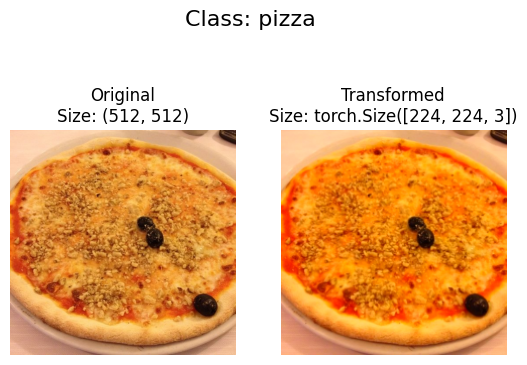

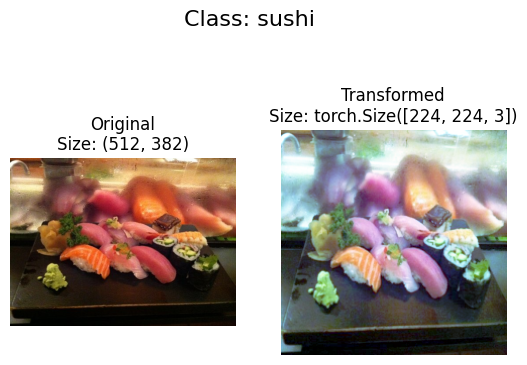

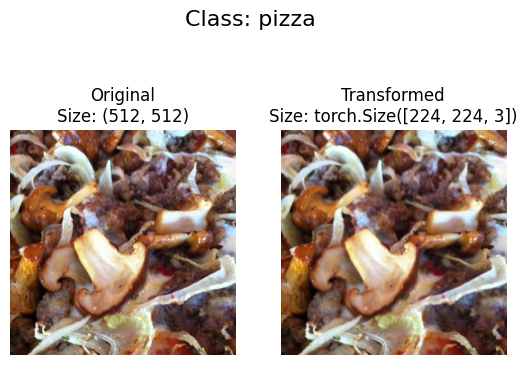

In [31]:
plot_transformed_images(
    image_paths= image_path_list,
    transform= train_transform,
    seed= None
)

#### 7. Model 0 : Tiny VGG without data agumentation


##### 7.1 Cretaing transform and loading data for model 0

In [32]:
# Create simple transform with no data agumenation

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
])


In [33]:
# 1. Load and transform data

train_data_simple = datasets.ImageFolder(
    root= train_dir,
    transform= simple_transform,
    target_transform= None,
)

test_data_simple = datasets.ImageFolder(
    root= test_dir,
    transform= simple_transform,
    target_transform= None,
)

In [34]:
#2. Turn the datasets into DataLoaders

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataLoader_simple = DataLoader(
    dataset= train_data_simple,
    batch_size= BATCH_SIZE,
    shuffle= True,
    num_workers= NUM_WORKERS
)

test_dataLoader_simple = DataLoader(
    dataset= test_data_simple,
    batch_size= BATCH_SIZE,
    shuffle= False,
    num_workers= NUM_WORKERS
)

In [35]:
class TinyVGG(nn.Module):
    """
    Model architechture that replicates the TinyVGG
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels= input_shape,
                out_channels=hidden_units,
                kernel_size= 3,
                stride = 1,
                padding=1), #Setting hyperparameters for 2d data
            nn.ReLU(),
            nn.Conv2d(
                in_channels= hidden_units,
                out_channels= hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1
            ),
            nn.ReLU(),
            nn.MaxPool2d( kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features= hidden_units*16*16,
                out_features= output_shape
            )
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [36]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(
    input_shape= 3 ,# Num of color channels in our image
    hidden_units= 16,
    output_shape= len(class_names)
).to(device)

In [37]:
# pass dummy data through our model to find the units or shape  after flatten layer

# Get a single image batch

image_batch, label_batch = next(iter(train_dataLoader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [38]:
model_0(image_batch.to(device))

tensor([[-1.7149e-02,  3.8866e-04,  4.6768e-03],
        [-1.8497e-02, -3.3516e-03, -2.3682e-03],
        [-1.6443e-02, -3.7661e-03, -6.3871e-05],
        [-1.6176e-02, -2.8692e-03,  4.5269e-04],
        [-1.5698e-02,  1.4704e-03, -6.3390e-04],
        [-1.2353e-02, -4.3040e-03,  4.3637e-03],
        [-1.4943e-02, -6.1984e-03, -3.3503e-03],
        [-1.5791e-02,  2.8179e-03,  1.2992e-04],
        [-1.4960e-02, -3.3791e-03,  1.9772e-03],
        [-1.8481e-02, -3.2830e-03,  3.4062e-04],
        [-1.7213e-02, -5.2264e-03,  6.4697e-03],
        [-1.8505e-02, -4.3773e-03,  8.9996e-04],
        [-2.2444e-02, -1.6588e-04, -1.9235e-03],
        [-1.8782e-02, -9.0293e-04, -1.7094e-03],
        [-2.0324e-02, -3.4257e-03, -9.1769e-04],
        [-2.0757e-02, -3.5295e-04,  5.0126e-03],
        [-1.6273e-02, -5.3398e-03, -1.2656e-03],
        [-2.1963e-02, -8.9451e-04,  1.3405e-03],
        [-1.3160e-02, -2.4869e-03,  3.4713e-03],
        [-1.6351e-02, -2.6967e-03,  1.6266e-03],
        [-1.6438e-02

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_0.parameters(),
    lr=0.001
)

In [40]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        #6. Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim =1), dim =1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)

    model.eval() # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            #6. Calculate accuracy metric
            test_pred_labels = torch.argmax(torch.softmax(test_pred, dim =1), dim =1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss, test_acc

In [41]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [42]:
# # Import tqdm for progress bar
# from tqdm.auto import tqdm
# from helper_functions import accuracy_fn

# # Set the seed and start the timer
# torch.manual_seed(42)
# train_time_start_on_gpu = timer()

# # Set the number of epochs (we'll keep this small for faster training times)
# epochs = 30

# # Create empty arrays for train and test loss and train and test accuracy
# train_loss_array = []
# train_acc_array = []
# test_loss_array = []
# test_acc_array = []

# # Create training and testing loop
# for epoch in tqdm(range(epochs)):
#     print(f"Epoch: {epoch}\n-------")

#     # Train
#     train_loss, train_acc = train_step(
#         model=model_0,
#         data_loader=train_dataLoader_simple,
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         accuracy_fn=accuracy_fn,
#         device=device
#     )
#     train_loss_array.append(train_loss)
#     train_acc_array.append(train_acc)

#     # Test
#     test_loss, test_acc = test_step(
#         model=model_0,
#         data_loader=train_dataLoader_simple,
#         loss_fn=loss_fn,
#         accuracy_fn=accuracy_fn,
#         device=device
#     )
#     test_loss_array.append(test_loss)
#     test_acc_array.append(test_acc)

# # Calculate training time
# train_time_end_on_gpu = timer()
# total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
#                                            end=train_time_end_on_gpu,
#                                            device=str(next(model_0.parameters()).device))

# result_dict = {
#     'train_loss': train_loss_array,
#     'train_acc': train_acc_array,
#     'test_loss': test_loss_array,
#     'test_acc': test_acc_array
# }

# result_dict

In [43]:
import torchinfo
from torchinfo import summary

summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
│    └─ReLU: 2-2                         [1, 16, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 16, 64, 64]           2,320
│    └─ReLU: 2-4                         [1, 16, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 16, 32, 32]           2,320
│    └─ReLU: 2-7                         [1, 16, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 16, 32, 32]           2,320
│    └─ReLU: 2-9                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 16, 16, 16]           --
├─Seq

In [44]:
# # 1. Load and transform data
# from torchvision import datasets
# train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
# test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# # 2. Turn data into DataLoaders
# import os
# from torch.utils.data import DataLoader

# # Setup batch size and number of workers
# BATCH_SIZE = 32
# NUM_WORKERS = os.cpu_count()
# print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# # Create DataLoader's
# train_dataloader_simple = DataLoader(train_data_simple,
#                                      batch_size=BATCH_SIZE,
#                                      shuffle=True,
#                                      num_workers=NUM_WORKERS)

# test_dataloader_simple = DataLoader(test_data_simple,
#                                     batch_size=BATCH_SIZE,
#                                     shuffle=False,
#                                     num_workers=NUM_WORKERS)

# train_dataloader_simple, test_dataloader_simple

In [45]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion



In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=16,
                  output_shape=len(train_data.classes)
                ).to(device)


In [47]:
# def train_step(model: torch.nn.Module,
#                dataloader: torch.utils.data.DataLoader,
#                loss_fn: torch.nn.Module,
#                optimizer: torch.optim.Optimizer):
#     # Put model in train mode
#     model.train()

#     # Setup train loss and train accuracy values
#     train_loss, train_acc = 0, 0

#     # Loop through data loader data batches
#     for batch, (X, y) in enumerate(dataloader):
#         # Send data to target device
#         X, y = X.to(device), y.to(device)

#         # 1. Forward pass
#         y_pred = model(X)

#         # 2. Calculate  and accumulate loss
#         loss = loss_fn(y_pred, y)
#         train_loss += loss.item()

#         # 3. Optimizer zero grad
#         optimizer.zero_grad()

#         # 4. Loss backward
#         loss.backward()

#         # 5. Optimizer step
#         optimizer.step()

#         # Calculate and accumulate accuracy metric across all batches
#         y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
#         train_acc += (y_pred_class == y).sum().item()/len(y_pred)

#     # Adjust metrics to get average loss and accuracy per batch
#     train_loss = train_loss / len(dataloader)
#     train_acc = train_acc / len(dataloader)
#     return train_loss, train_acc

In [48]:
# def test_step(model: torch.nn.Module,
#               dataloader: torch.utils.data.DataLoader,
#               loss_fn: torch.nn.Module):
#     # Put model in eval mode
#     model.eval()

#     # Setup test loss and test accuracy values
#     test_loss, test_acc = 0, 0

#     # Turn on inference context manager
#     with torch.inference_mode():
#         # Loop through DataLoader batches
#         for batch, (X, y) in enumerate(dataloader):
#             # Send data to target device
#             X, y = X.to(device), y.to(device)

#             # 1. Forward pass
#             test_pred_logits = model(X)

#             # 2. Calculate and accumulate loss
#             loss = loss_fn(test_pred_logits, y)
#             test_loss += loss.item()

#             # Calculate and accumulate accuracy
#             test_pred_labels = test_pred_logits.argmax(dim=1)
#             test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

#     # Adjust metrics to get average loss and accuracy per batch
#     test_loss = test_loss / len(dataloader)
#     test_acc = test_acc / len(dataloader)
#     return test_loss, test_acc

In [49]:
# from tqdm.auto import tqdm

# # 1. Take in various parameters required for training and test steps
# def train(model: torch.nn.Module,
#           train_dataloader: torch.utils.data.DataLoader,
#           test_dataloader: torch.utils.data.DataLoader,
#           optimizer: torch.optim.Optimizer,
#           loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
#           epochs: int = 5):

#     # 2. Create empty results dictionary
#     results = {"train_loss": [],
#         "train_acc": [],
#         "test_loss": [],
#         "test_acc": []
#     }

#     # 3. Loop through training and testing steps for a number of epochs
#     for epoch in tqdm(range(epochs)):
#         train_loss, train_acc = train_step(model=model,
#                                            dataloader=train_dataloader,
#                                            loss_fn=loss_fn,
#                                            optimizer=optimizer)
#         test_loss, test_acc = test_step(model=model,
#             dataloader=test_dataloader,
#             loss_fn=loss_fn)

#         # 4. Print out what's happening
#         print(
#             f"Epoch: {epoch+1} | "
#             f"train_loss: {train_loss:.4f} | "
#             f"train_acc: {train_acc:.4f} | "
#             f"test_loss: {test_loss:.4f} | "
#             f"test_acc: {test_acc:.4f}"
#         )

#         # 5. Update results dictionary
#         results["train_loss"].append(train_loss)
#         results["train_acc"].append(train_acc)
#         results["test_loss"].append(test_loss)
#         results["test_acc"].append(test_acc)

#     # 6. Return the filled results at the end of the epochs
#     return results

In [50]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 30

# Create empty arrays for train and test loss and train and test accuracy
train_loss_array = []
train_acc_array = []
test_loss_array = []
test_acc_array = []

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    # Train
    train_loss, train_acc = train_step(
        model=model_1,
        data_loader=train_dataLoader_simple,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    train_loss_array.append(train_loss)
    train_acc_array.append(train_acc)

    # Test
    test_loss, test_acc = test_step(
        model=model_1,
        data_loader=train_dataLoader_simple,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss_array.append(test_loss)
    test_acc_array.append(test_acc)

# Calculate training time
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                           end=train_time_end_on_gpu,
                                           device=str(next(model_1.parameters()).device))

result_dict1 = {
    'train_loss': train_loss_array,
    'train_acc': train_acc_array,
    'test_loss': test_loss_array,
    'test_acc': test_acc_array
}

result_dict

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.09987 | Train accuracy: 0.33%
Test loss: 1.10001 | Test accuracy: 0.33%

Epoch: 1
-------
Train loss: 1.10060 | Train accuracy: 0.33%
Test loss: 1.09992 | Test accuracy: 0.33%

Epoch: 2
-------
Train loss: 1.09781 | Train accuracy: 0.45%
Test loss: 1.09839 | Test accuracy: 0.33%

Epoch: 3
-------
Train loss: 1.09940 | Train accuracy: 0.33%
Test loss: 1.09758 | Test accuracy: 0.45%

Epoch: 4
-------
Train loss: 1.09880 | Train accuracy: 0.33%
Test loss: 1.09809 | Test accuracy: 0.33%

Epoch: 5
-------
Train loss: 1.09837 | Train accuracy: 0.33%
Test loss: 1.09817 | Test accuracy: 0.33%

Epoch: 6
-------
Train loss: 1.09766 | Train accuracy: 0.45%
Test loss: 1.10009 | Test accuracy: 0.33%

Epoch: 7
-------
Train loss: 1.09987 | Train accuracy: 0.33%
Test loss: 1.09987 | Test accuracy: 0.33%

Epoch: 8
-------
Train loss: 1.09728 | Train accuracy: 0.45%
Test loss: 1.09850 | Test accuracy: 0.33%

Epoch: 9
-------
Train loss: 1.09982 | Train accuracy: 0.33%
Tes

NameError: name 'result_dict' is not defined

In [ ]:

summary(model_1, input_size=[1,3,64,64])

In [ ]:
# Check the model_0_results keys
# model_1_results.keys()

In [ ]:
from typing import Dict


def plot_loss_curves(results: Dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [ ]:
plot_loss_curves(result_dict1)

In [ ]:
# plot_loss_curves(result_dict)